In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [4]:
from zoobot.active_learning.metrics import IterationState
import pickle

In [5]:
import tensorflow_probability as tfp

In [6]:
os.chdir('/home/walml/repos/zoobot')

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [8]:
catalog_loc = 'data/gz2/gz2_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/gz2' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [9]:

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
    'bar',
    'bulge-size'
]

# decals cols
# version = 'decals'
# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
#     'bar_strong',
#     'bar_weak',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_large',
#     'bulge-size_moderate',
#     'bulge-size_small',
#     'bulge-size_none'
# ]

# gz2 cols
version = 'gz2'
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'bar_yes',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_obvious',
    'bulge-size_just-noticeable',
    'bulge-size_no'
]



schema = losses.Schema(label_cols, questions, version=version)

batch_size = 8
initial_size = 300
# initial_size = 128
crop_size = int(initial_size * 0.75)
# crop_size = 128
final_size = 224
channels = 3

n_samples = 10


{has-spiral-arms, indices 0 to 1, asked after None: (0, 1)}


In [10]:
folders = [
    'latest_dirichlet_active_2p5_dual',
    'latest_dirichlet_active_2p5_dual_skip500',
    'latest_dirichlet_active_2p5_dual_skip1500_repeat',
    'latest_dirichlet_active_2p5_model_c',
    'latest_dirichlet_active_2p5_model_d',
    'latest_dirichlet_active_2p5_model_e'
]
samples_list = []
id_strs_list = []
acquisitions_list = []

for folder in folders:
    state_loc = f'results/temp/{folder}/iteration_0/state.pickle'
    with open(state_loc, 'rb') as f:
        state = pickle.load(f)
        samples = state.samples
        print(len(samples))
        if len(samples) == 1:
            samples = samples[0]
    samples_list.append(samples)
    id_strs_list.append(state.id_strs)
    acquisitions_list.append(state.acquisitions)

16384
16384
16384
1
1
1


In [11]:
id_strs_list[2][:10]

['dr7objid_587739132962406756',
 'dr7objid_588010358538633456',
 'dr7objid_588016891708768414',
 'dr7objid_587735431226130460',
 'dr7objid_587742629062181111',
 'dr7objid_587733081347850349',
 'dr7objid_587731520671776948',
 'dr7objid_587739845388206341',
 'dr7objid_587732589570752553',
 'dr7objid_587738946662826176']

In [12]:
id_strs_list[3][:10]

['dr7objid_587739132962406756',
 'dr7objid_588010358538633456',
 'dr7objid_588016891708768414',
 'dr7objid_587735431226130460',
 'dr7objid_587742629062181111',
 'dr7objid_587733081347850349',
 'dr7objid_587731520671776948',
 'dr7objid_587739845388206341',
 'dr7objid_587732589570752553',
 'dr7objid_587738946662826176']

In [13]:
def visualise_positions(id_strs_to_viz, all_id_strs, invert=False):
    missing = pd.Series(all_id_strs).isin(id_strs_to_viz)
    if invert:
        missing = ~missing
    print(missing.sum())
    fig, ax = plt.subplots(figsize=(20, 4))
    for i in missing[missing].index:
        ax.axvline(i)

1024


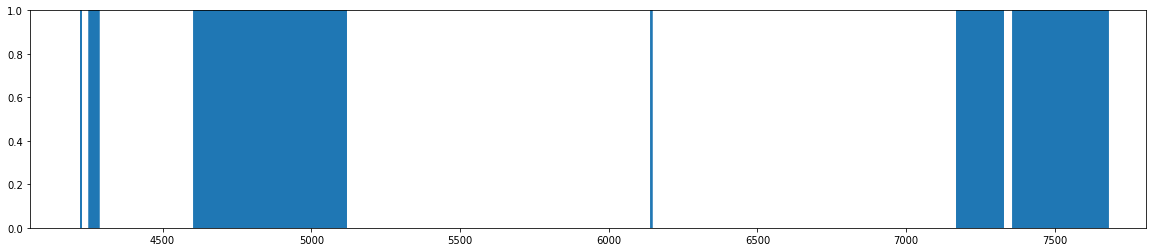

In [14]:
visualise_positions(id_strs_list[3], id_strs_list[2], invert=True)

In [16]:
visualise_positions(id_strs_to_viz, id_strs_list[2], invert=False)

NameError: name 'id_strs_to_viz' is not defined

In [ ]:
# check which ids were acquired, by reading the iteration 1 acquired shard

In [17]:
def get_id_strs_in_shard(loc):
    feature_spec = input_utils.get_feature_spec({'id_str': 'string'})
    id_str_dataset = input_utils.get_dataset(loc, feature_spec, batch_size=1, shuffle=False, repeat=False, drop_remainder=False)
    id_strs = [str(d['id_str'].numpy().squeeze())[2:-1] for d in id_str_dataset]
    return id_strs

In [18]:
# folder = 'latest_dirichlet_active_2p5_dual_repeat'
# folder = 'latest_dirichlet_active_2p5_dual_skip1500_repeat'
# folder = 'latest_dirichlet_active_2p5_model_e'
folder = 'latest_dirichlet_active_2p5_6model_effnet'
locs = glob.glob(f'results/temp/{folder}/iteration_1/acquired_tfrecords/*.tfrecord')

In [19]:
locs

['results/temp/latest_dirichlet_active_2p5_6model_effnet/iteration_1/acquired_tfrecords/s300_shard_2.tfrecord',
 'results/temp/latest_dirichlet_active_2p5_6model_effnet/iteration_1/acquired_tfrecords/s300_shard_1.tfrecord',
 'results/temp/latest_dirichlet_active_2p5_6model_effnet/iteration_1/acquired_tfrecords/s300_shard_0.tfrecord']

In [20]:
state_loc = f'results/temp/{folder}/iteration_0/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)

In [21]:
ids_in_shard = get_id_strs_in_shard(locs[0])

In [22]:
loc = f'results/temp/{folder}/instructions/subjects_requested.json'
with open(loc, 'r') as f:
    id_strs_requested = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results/temp/latest_dirichlet_active_2p5_6model_effnet/instructions/subjects_requested.json'

In [ ]:
# worryingly, these still form the weird pattern vs. the state.id_strs variable!

In [23]:
acq = state.acquisitions
ids = state.id_strs
top_ids = [ids[n] for n in np.argsort(acq)[::-1][:1024]]

In [24]:
# visualise_positions(ids_in_shard, state.id_strs, invert=False)

1024


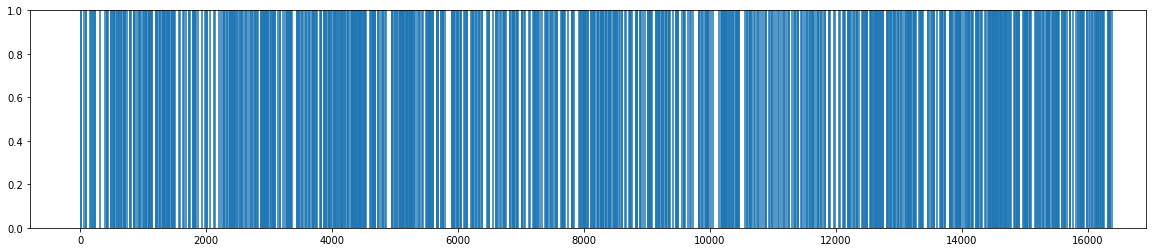

In [25]:
visualise_positions(top_ids, state.id_strs, invert=False)

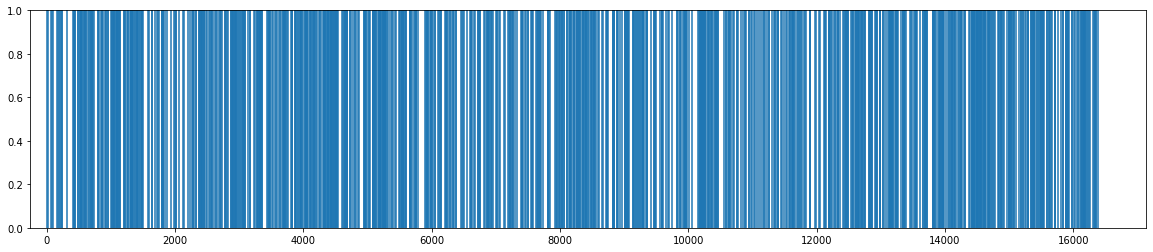

In [26]:
fig, ax = plt.subplots(figsize=(20, 4))
for i in np.argsort(state.acquisitions)[::-1][:1024]:
    ax.axvline(i)

In [27]:
visualise_positions(id_strs_requested, state.id_strs, invert=False)

NameError: name 'id_strs_requested' is not defined

In [ ]:
# args_to_sort = np.argsort(acq)[::-1]
args_to_sort = np.argsort(np.random.rand(len(ids)))
subjects = np.arange(len(ids))
n_subjects_to_acquire = 1024
top_acquisition_subjects = [subjects[i] for i in args_to_sort][1500:n_subjects_to_acquire+1500]

In [ ]:
# top_acquisition_subjects

In [ ]:
len(ids_in_shard)

In [ ]:
top_ids[:2]

In [ ]:
ids_in_shard[:2]

In [ ]:
len(set(top_ids) - set(ids_in_shard))

In [ ]:
visualise_positions(top_ids, id_strs_list[0], invert=False)

In [ ]:
folders = [
    'latest_dirichlet_active_2p5_dual',
    'latest_dirichlet_active_2p5_dual_skip500',
    'latest_dirichlet_active_2p5_dual_skip1500_repeat',
#     'latest_dirichlet_active_2p5_model_c',
    'latest_dirichlet_active_2p5_model_d',
    'latest_dirichlet_active_2p5_model_e'
]
samples_list = []
id_strs_list = []
acquisitions_list = []

for folder in folders:
    state_loc = f'results/temp/{folder}/iteration_0/state.pickle'
    with open(state_loc, 'rb') as f:
        state = pickle.load(f)
        samples = state.samples
        print(len(samples))
        if len(samples) == 1:
            samples = samples[0]
    samples_list.append(samples)
    id_strs_list.append(state.id_strs)
#     acquisitions_list.append(state.acquisitions)

In [ ]:
[len(i) for i in id_strs_list]

In [ ]:
len(set(id_strs_list[3]).intersection(set(id_strs_list[2])))

In [ ]:
len(set(id_strs_list[2]) - set(id_strs_list[3]))

In [ ]:
for s in samples_list:
    print(len(s))
    print(s.shape)

In [ ]:
new = True
if new:
    mi, predictive, expected = acquisition_utils.get_multimodel_acq(samples_list, schema)
    mi.shape

In [ ]:
if new:
    np.savetxt('results/temp/manual_multimodel_acquisitions.npy', mi)

In [ ]:
np.loadtxt('results/temp/manual_multimodel_acquisitions.npy')

In [ ]:
plt.hist(mi, bins=30)

In [ ]:
import matplotlib as mpl
cycler = mpl.rcParams['axes.prop_cycle']
# https://matplotlib.org/cycler/
colors = [c['color'] for c in cycler]

In [ ]:
colors

In [ ]:
assert len(colors) > len(samples_list)

In [ ]:
len(samples_list)

In [ ]:
def show_predictions(samples_list, catalog, id_strs, question, answer, sort_order=None, n_examples=5):  
    
    if sort_order is None:
        id_str_sorted = id_strs
#         catalog_sorted = catalog
    else:
#         catalog_sorted = catalog[sort_order]
        id_str_sorted = [id_strs[n] for n in sort_order]

    fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(10, 3 * n_examples))
    for n in range(n_examples):
        
        galaxy = catalog[catalog['id_str'] == id_str_sorted[n]].squeeze()

        row = axes[n]
        total_votes = galaxy['smooth-or-featured_featured-or-disk'].astype(np.float32)
#         total_votes = 40.
#         print(total_votes)
        votes = np.linspace(0., total_votes)
        x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
        votes_this_answer = x[:, answer.index - question.start_index]

        for model_n, samples in enumerate(samples_list):

            if sort_order is None:
                samples_sorted = samples
            else:
                samples_sorted = samples[sort_order]

            ax = row[0]

            all_log_probs = []
            color = colors[model_n]
            n_samples = samples.shape[2]
            for d in range(n_samples):
                concentrations = tf.constant(samples_sorted[n, question.start_index:question.end_index+1, d].astype(np.float32))
                log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
                all_log_probs.append(log_probs)
                ax.plot(votes_this_answer, log_probs, alpha=.15, color=color)
            all_log_probs = np.array(all_log_probs).mean(axis=0)
            ax.plot(votes_this_answer, all_log_probs, linewidth=2., color=color)
            ax.axvline(galaxy[answer.text], color='k', linestyle='--')
            
            ax = row[1]
            ax.imshow(np.array(Image.open(galaxy['file_loc'])))
            ax.axis('off')

In [ ]:
question = schema.questions[0]
answer = question.answers[0]
sort_order = np.argsort(mi.squeeze())
# print(sort_order)
show_predictions(samples_list, catalog, id_strs_list[0], question, answer, sort_order=sort_order, n_examples=8)

In [ ]:
sort_order = np.argsort(mi.squeeze())[::-1]
# print(sort_order)
show_predictions(samples_list, catalog, id_strs_list[0], question, answer, sort_order=sort_order, n_examples=8)

In [ ]:
acq_df = pd.DataFrame(data={'id_str': id_strs_list[0], 'acquisition': mi.squeeze()})
df = pd.merge(acq_df, catalog, on='id_str', how='left')

In [ ]:
df['has-spiral-arms_fraction'] = df['has-spiral-arms_yes'] / df['has-spiral-arms_total-votes']
df['log_acquisition'] = np.log10(df['acquisition']+1e-5)

In [ ]:
# copied from touch table
def quality_check(df, n_bins=10, n_galaxies_per_bin=10):

#     df['binned_acq'], bins = pd.cut(df['acquisition'], n_bins, labels=False, retbins=True)
    df['binned_acq'], bins = pd.cut(df['log_acquisition'], n_bins, labels=False, retbins=True)
    print(bins)
    print(df['binned_acq'].value_counts())
    
    scale = 3
    plt.figure(figsize=(scale * n_galaxies_per_bin, scale * n_bins))
    gs1 = gridspec.GridSpec(n_galaxies_per_bin, n_bins)
    gs1.update(wspace=0.0, hspace=0.0)
    for bin_n in range(n_bins):
        selected_df = df.query('binned_acq == {}'.format(bin_n))
        selected_df = selected_df.sample(len(selected_df))  # shuffle
        for galaxy_n in range(n_galaxies_per_bin):
            if galaxy_n < len(selected_df):
                galaxy = selected_df.iloc[galaxy_n]
                image = Image.open(galaxy['file_loc'])
                ax = plt.subplot(gs1[galaxy_n, bin_n])
                ax.imshow(image)
                ax.text(50, 50, 'Spiral = {:.2f}'.format(galaxy['has-spiral-arms_fraction']), fontsize=16, color='r')
#                 ax.text(50, 120, 'N = {}'.format(galaxy['total']), fontsize=16, color='r')
                if galaxy_n == 0:
                    ax.text(80, -50, 'Feat: {:.2f} to {:.2f}'.format(bins[bin_n], bins[bin_n + 1]), fontsize=16, color='black')
                ax.axis('off')
#     plt.savefig('touch_table_retirement_{}.pdf'.format(retirement_limit))
    return df

In [ ]:
catalog.columns.values

In [ ]:
sns.jointplot(df['log_acquisition'], df['has-spiral-arms_fraction'], kind='hex')

In [ ]:
sns.jointplot(df['log_acquisition'], df['has-spiral-arms_fraction'], kind='hex')

In [ ]:
df.sort_values('log_acquisition', ascending=False).iloc[1024]['log_acquisition']

In [ ]:
df.sort_values('log_acquisition', ascending=False).iloc[int(len(df)/2)]['log_acquisition']

In [ ]:
df['log_acquisition'].hist(bins=30)

In [ ]:
_ = quality_check(df.query('log_acquisition > -3.'))